# Part II - Uncovering Patterns in Ford GoBike Trips: A Data-Driven Exploration
## by Arein Fetyani

## Investigation Overview

> This analysis aims to present meaningful insights from the Ford GoBike System dataset by examining how trip duration interacts with user type, gender, and trip start time. The focus is on identifying behavioral differences between subscribers and customers, particularly in distinguishing commuting habits from leisure-oriented usage. The conclusions drawn here build on earlier exploratory analysis and are illustrated using refined, presentation-ready visualizations.

## Dataset Overview and Executive Summary

> The dataset consists of trip-level records from the Ford GoBike bike-share program during February 2019. It includes information such as ride duration, rider classification (subscriber or customer), gender, and trip start time.

Key Insights:
* Subscribers frequently use the service during peak commute periods—typically around 8 AM and 5 PM—and tend to take shorter trips.

* Customers exhibit greater flexibility in ride times and generally take longer trips on average.

* While gender has minimal effect on trip length, customers consistently take longer rides across all gender groups.

* By examining the interaction of user type, start hour, and trip duration, we see a clear distinction between commuter behavior (subscribers) and recreational use (customers).


In [9]:
# Import packages and set up plotting style
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seaborn theme for clean plots
sns.set_theme(style='whitegrid', context='talk')

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


In [10]:
# Load dataset as in Part I
df = pd.read_csv('201902-fordgobike-tripdata.csv')

# Check shape and preview
print(f"Loaded '201902-fordgobike-tripdata.csv' with shape {df.shape}")
print("Columns:", list(df.columns))
df.head()


Loaded '201902-fordgobike-tripdata.csv' with shape (183412, 16)
Columns: ['duration_sec', 'start_time', 'end_time', 'start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type', 'member_birth_year', 'member_gender', 'bike_share_for_all_trip']


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


We load the February 2019 Ford GoBike trip data into a pandas DataFrame. The dataset contains individual trip records, including trip duration, user type, gender, and trip start time.


## 1) Trip Duration Distribution

This section examines the distribution of trip durations (in seconds) to identify typical ride lengths and detect any irregularities. Due to the presence of extreme values (very long trips), the top 1% of durations are excluded to provide a clearer view of common usage patterns.


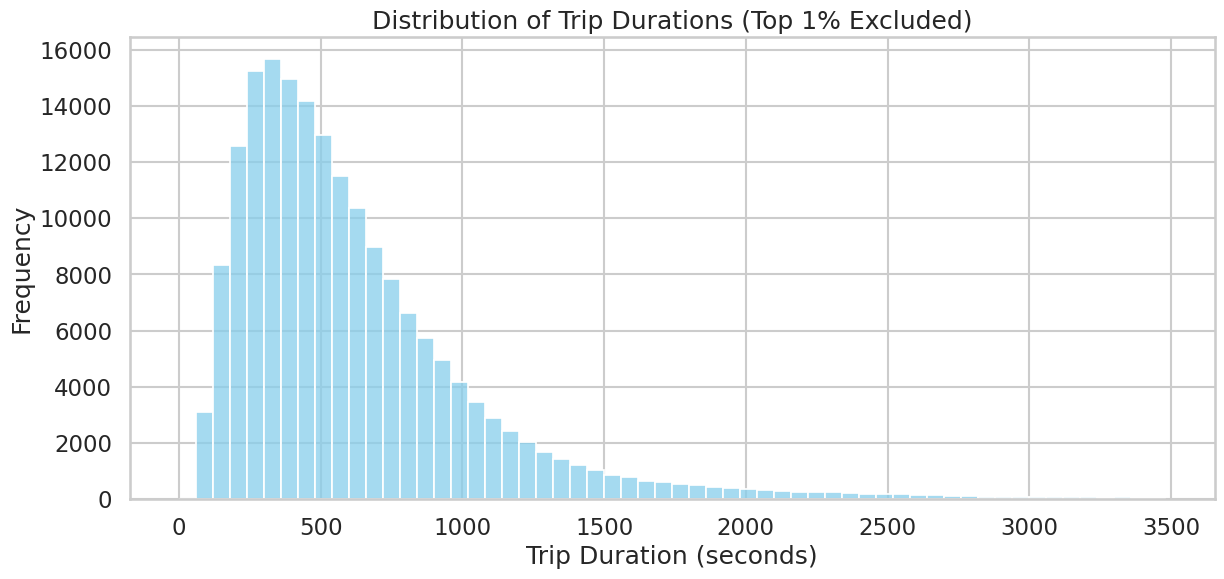

In [11]:
# Calculate 99th percentile cutoff
cutoff = df['duration_sec'].quantile(0.99)

# Plot histogram of trip duration (top 1% excluded)
plt.figure(figsize=(14, 6))  # Consistent plot size
bins = np.arange(0, cutoff + 60, 60)  # 1-minute bins

sns.histplot(df[df['duration_sec'] <= cutoff]['duration_sec'], bins=bins, color='skyblue')

plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Durations (Top 1% Excluded)')
plt.show()


**Key Insight:**  
Trip durations are heavily skewed to the right, with the majority of rides lasting less than 1,000 seconds (approximately 16–17 minutes). Removing the longest 1% of trips helps to clarify the overall pattern, which would otherwise be obscured by extreme values.


## 2) Trip Duration by User Type

This box plot compares trip duration distributions for Subscribers and Customers. It highlights differences in both spread and median values between the two groups, offering insight into how casual riders and regular users engage with the service.


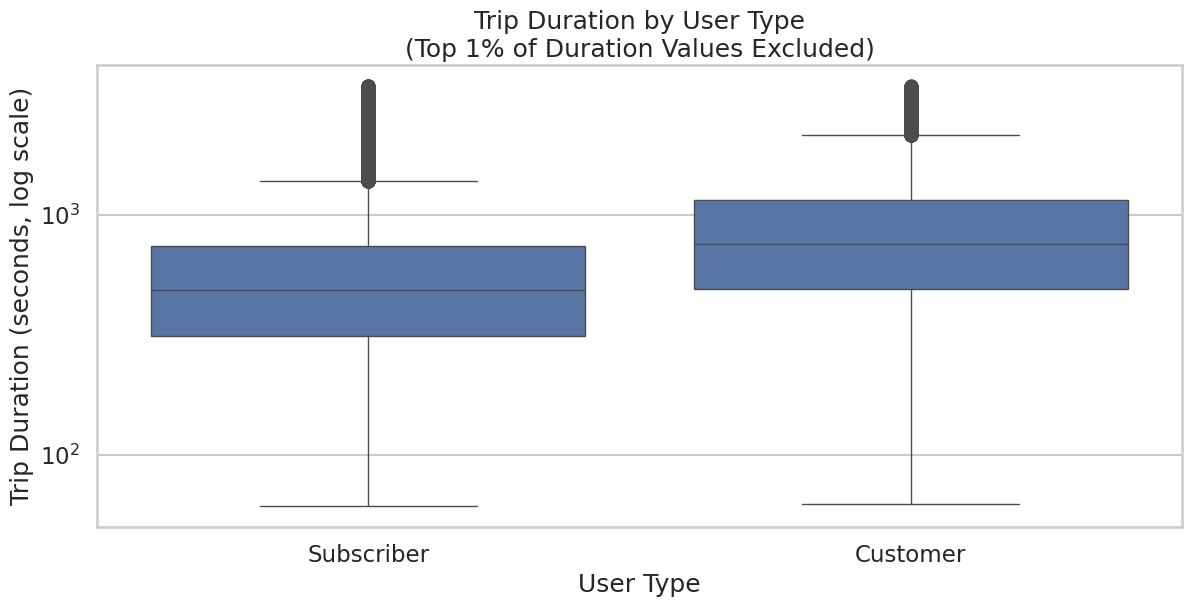

In [12]:
# Box plot of trip duration by user type, excluding top 1% of durations
plt.figure(figsize=(14, 6))
sns.boxplot(x='user_type', y='duration_sec', 
            data=df.query('duration_sec < @df.duration_sec.quantile(0.99)'))
plt.yscale('log')  # Log scale to handle skewed data

plt.title('Trip Duration by User Type\n(Top 1% of Duration Values Excluded)')
plt.xlabel('User Type')
plt.ylabel('Trip Duration (seconds, log scale)')
plt.show()


**Key Insight:**  
The box plot shows that customers typically take longer and more varied trips compared to subscribers. Customers have a higher median trip duration and a wider interquartile range, with numerous long-duration outliers. Subscribers, on the other hand, exhibit shorter and more consistent trip lengths with fewer extremes. This suggests that subscribers likely use the service for routine, short-distance travel—such as commuting—while customers may use it more sporadically for leisure or longer outings.


## 3) Average Trip Duration by Start Hour and User Type

This heatmap illustrates how average trip duration changes throughout the day for each user type (Subscriber vs. Customer). By breaking it down by hour and user category, we can observe time-based trends and distinguish between the behaviors of casual and frequent riders.


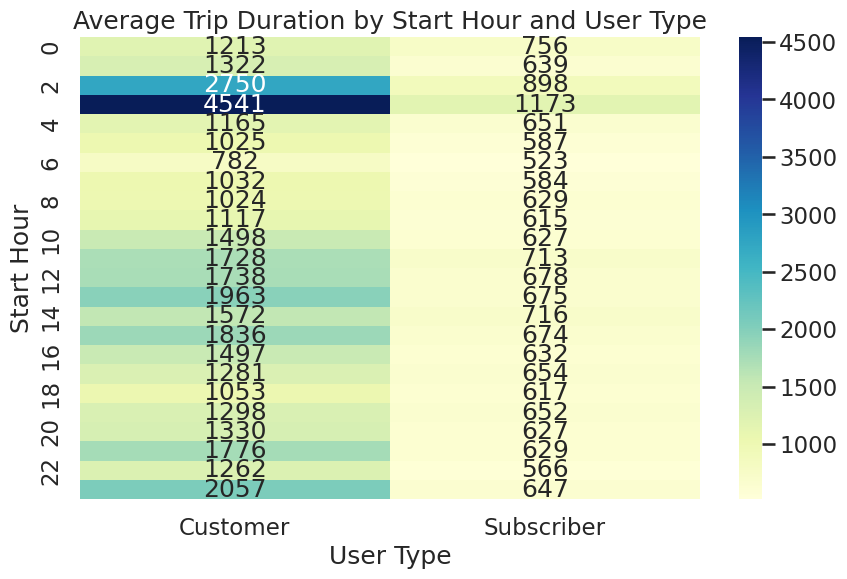

In [13]:
# Make sure start_hour exists
df['start_time'] = pd.to_datetime(df['start_time'])
df['start_hour'] = df['start_time'].dt.hour

# Compute pivot table for average duration
pivot_table = df.pivot_table(index='start_hour',
                             columns='user_type',
                             values='duration_sec',
                             aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Average Trip Duration by Start Hour and User Type')
plt.xlabel('User Type')
plt.ylabel('Start Hour')
plt.show()


**Key Insight:**  
The heatmap reveals that customers tend to take longer trips on average, particularly around midday, suggesting usage for leisure or tourism. In contrast, subscribers exhibit shorter and more consistent trip durations throughout the day, with modest increases during typical commute periods in the morning and late afternoon.


## Conclusion

This analysis uncovered meaningful trends in bike-share usage through a series of targeted visualizations.  
We started by analyzing the distribution of trip durations, which showed that most rides are short and that the data is highly right-skewed, with a few exceptionally long trips.  
We then compared trip durations by user type, observing that customers generally take longer, more variable rides, while subscribers tend to make shorter, more predictable trips—suggesting regular, commuter-focused usage for subscribers and more occasional or recreational use for customers.  
Lastly, we looked at how average trip duration changes throughout the day by user type. The heatmap demonstrated that customers take longer rides midday, while subscribers maintain consistent trip lengths with slight increases during morning and evening commute hours.

Taken together, these visualizations illustrate that trip duration is shaped not only by user type but also by the time of day. The clear contrast between casual and frequent riders offers valuable guidance for decisions around bike allocation, pricing models, and marketing strategies tailored to user behavior and time-based trends.
